In [1]:
import os 
from dotenv import load_dotenv, load_dotenv

load_dotenv()

True

In [2]:
os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')


In [3]:
from langchain_groq import ChatGroq

llm=ChatGroq(model='llama-3.1-8b-instant')
llm.invoke('hi').content

'How can I assist you today?'

In [4]:
from typing import Annotated, List
import operator
import json
from typing_extensions import Literal, TypedDict
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage


In [5]:
class Section(BaseModel):
    name: str = Field(description="Name for this section of the report")
    description: str = Field(description="Brief Overview of the main topics and concepts of the section")

class Sections(BaseModel):
    sections: list[Section] = Field(description="Sections of the report")

# Use JSON-format prompting instead of function calling to avoid Groq tool_use restrictions
def parse_sections(text: str) -> Sections:
    try:
        data = json.loads(text)
        return Sections(**data)
    except Exception:
        # Attempt to extract JSON block from text
        import re
        matches = re.findall(r"\{[\s\S]*\}", text)
        for m in matches:
            try:
                data = json.loads(m)
                return Sections(**data)
            except Exception:
                continue
        raise ValueError("Failed to parse sections JSON from model output")

planner_prompt = (
    "You are a planning assistant. Return ONLY valid JSON with this schema: "
    '{"sections": [{"name": string, "description": string}, ...]}.'
    " No extra text."
)


# create workers Dynamically in langgraph

In [6]:
from langgraph.types import Send

class State(TypedDict):
    topic: str
    sections: list[Section]
    completed_sections: Annotated[list, operator.add]
    final_report: str

class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


In [7]:
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Ask the LLM to return JSON and parse it
    response = llm.invoke(
        [
            SystemMessage(content=planner_prompt),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )
    parsed = parse_sections(response.content)

    print("Report Sections:", parsed)

    return {"sections": parsed.sections}

In [8]:
def llm_call(state: WorkerState):
    section = llm.invoke(
        [
            SystemMessage(
                content=(
                    "Write a report section following the provided name and description. "
                    "Include no preamble for each section. Use markdown formatting."
                )
            ),
            HumanMessage(
                content=(
                    f"Here is the section name: {state['section'].name} and description: "
                    f"{state['section'].description}"
                )
            ),
        ]
    )
    return {"completed_sections": [section.content]}

In [9]:
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    return [Send("llm_call", {"section": s}) for s in state["sections"]]

In [10]:
def synthesizer(state: State):
    """Synthesize full report from sections"""

    completed_sections = state["completed_sections"]

    complete_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": complete_report_sections}


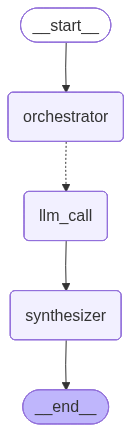

In [11]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

oechistrator_worker_builder = StateGraph(State)
oechistrator_worker_builder.add_node("orchestrator", orchestrator)
oechistrator_worker_builder.add_node("llm_call", llm_call)
oechistrator_worker_builder.add_node("synthesizer", synthesizer)

oechistrator_worker_builder.add_edge(START, "orchestrator")
oechistrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
oechistrator_worker_builder.add_edge("llm_call", "synthesizer")
oechistrator_worker_builder.add_edge("synthesizer", END)

orchestrator_worker = oechistrator_worker_builder.compile()

display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))


In [12]:
state = orchestrator_worker.invoke({"topic": "create a report on agentic ai rags"})

from IPython.display import Markdown

Markdown(state["final_report"])

Report Sections: sections=[Section(name='Introduction', description='Agentic AI refers to artificial intelligence systems that possess a sense of agency, autonomy, and self-awareness, enabling them to take actions and make decisions independently.'), Section(name='Types of Agentic AI', description='There are several types of agentic AI, including rule-based systems, machine learning models, and cognitive architectures. Each type has its strengths and limitations in terms of decision-making and action-taking capabilities.'), Section(name='Benefits of Agentic AI', description='Agentic AI can bring numerous benefits, such as increased efficiency, improved decision-making, and enhanced creativity. It can also enable humans to focus on higher-level tasks, leading to increased productivity and innovation.'), Section(name='Challenges and Risks', description='However, agentic AI also poses significant challenges and risks, including the potential for unintended consequences, bias, and job disp

### **Introduction**

Agentic AI refers to artificial intelligence systems that possess a sense of agency, autonomy, and self-awareness, enabling them to take actions and make decisions independently. This concept is crucial in the development of advanced AI technologies, as it allows for the creation of systems that can interact and adapt to their environment in a more human-like manner.

### **Key Characteristics**

- **Agency**: The ability to act independently and make decisions without being explicitly programmed.
- **Autonomy**: The capacity to operate without external control or supervision.
- **Self-Awareness**: The ability to have a sense of its own existence, goals, and limitations.

### **Implications of Agentic AI**

The development of agentic AI has significant implications for various fields, including:

- **Robotics**: Enabling robots to learn and adapt to new situations without human intervention.
- **Decision-Making**: Allowing AI systems to make decisions autonomously, without human oversight.
- **Human-AI Interaction**: Creating more natural and intuitive interfaces between humans and AI systems.

### **Challenges and Limitations**

While agentic AI holds great promise, it also raises several challenges and limitations, including:

- **Safety and Control**: Ensuring that agentic AI systems do not become uncontrollable or pose a threat to human safety.
- **Explainability**: Understanding how agentic AI systems make decisions and ensuring that their actions are transparent and explainable.
- **Value Alignment**: Aligning the goals and values of agentic AI systems with human values and ethics.

---

### Types of Agentic AI

#### Rule-Based Systems

* **Description**: Rule-based systems use a set of predefined rules to reason and take actions. These rules are typically created by humans and are used to represent domain-specific knowledge.
* **Strengths**: Rule-based systems are easy to understand and maintain, and they can be very effective in well-defined domains where the rules are clear.
* **Limitations**: Rule-based systems can struggle with uncertainty and ambiguity, and they can be inflexible in the face of changing circumstances.

#### Machine Learning Models

* **Description**: Machine learning models use data to learn and improve their decision-making capabilities. They can be trained on large datasets and can adapt to changing circumstances.
* **Strengths**: Machine learning models can handle uncertainty and ambiguity, and they can learn from experience.
* **Limitations**: Machine learning models require large amounts of data to train, and they can be slow to adapt to changing circumstances.

#### Cognitive Architectures

* **Description**: Cognitive architectures are software frameworks that simulate the structure and function of the human brain. They use a combination of rule-based and machine learning approaches to reason and take actions.
* **Strengths**: Cognitive architectures can simulate human-like decision-making and can handle complex, dynamic environments.
* **Limitations**: Cognitive architectures are still in the early stages of development, and they can be difficult to train and maintain.

---

### Benefits of Agentic AI

#### Increased Efficiency

Agentic AI can automate repetitive and mundane tasks, freeing up human resources to focus on more complex and strategic tasks. By streamlining processes and eliminating manual errors, agentic AI can lead to significant improvements in efficiency.

#### Improved Decision-Making

Agentic AI can analyze vast amounts of data, identify patterns, and provide data-driven recommendations. This enables humans to make more informed decisions, reducing the risk of errors and increasing the likelihood of success.

#### Enhanced Creativity

Agentic AI can generate new ideas, explore novel solutions, and collaborate with humans to create innovative products and services. By leveraging the strengths of both humans and AI, agentic AI can unlock new possibilities and drive innovation.

#### Enhanced Productivity and Innovation

By automating routine tasks and enabling humans to focus on higher-level tasks, agentic AI can lead to increased productivity and innovation. This can result in significant economic benefits, improved competitiveness, and enhanced overall well-being.

---

### Challenges and Risks

#### Unintended Consequences

- **Lack of Transparency**: Agentic AI systems may not provide clear explanations for their actions, making it difficult to understand and anticipate unintended consequences.
- **Complexity**: The complexity of agentic AI systems can lead to unforeseen interactions and outcomes, increasing the risk of unintended consequences.

#### Bias

- **Data Bias**: Agentic AI systems are only as good as the data they are trained on, and if the data is biased, the system will also be biased.
- **Lack of Diversity**: If the development team lacks diversity, it may lead to a lack of different perspectives, increasing the risk of bias in the system.

#### Job Displacement

- **Automation**: Agentic AI has the potential to automate many jobs, leading to significant job displacement.
- **Skills Obsolescence**: As agentic AI takes over routine tasks, workers may need to acquire new skills to remain relevant, but this can be a challenging and time-consuming process.

#### Mitigation Strategies

- **Transparency and Explainability**: Developing systems that provide clear explanations for their actions can help mitigate unintended consequences.
- **Diverse Development Teams**: Encouraging diversity in development teams can help identify and mitigate bias in the system.
- **Upskilling and Reskilling**: Providing workers with opportunities to acquire new skills can help mitigate job displacement.

#### Ensuring Responsible Development and Use

- **Regulation**: Establishing clear regulations and guidelines for the development and use of agentic AI can help ensure that it is developed and used responsibly.
- **Public Engagement**: Engaging with the public about the potential risks and benefits of agentic AI can help build trust and ensure that it is used in a way that benefits society as a whole.

---

### Real-World Applications

#### Robotics

Agentic AI is being integrated into robots to enable them to perform complex tasks autonomously. These robots can learn from their environment and adapt to new situations, making them ideal for applications such as assembly lines, search and rescue, and service robots. For instance, agentic AI-powered robots can assist in tasks like cleaning, cooking, and delivering items, making daily life easier and more efficient.

#### Autonomous Vehicles

Agentic AI is also being used in the development of autonomous vehicles, which can navigate through roads and traffic without human intervention. These vehicles use a combination of sensors, mapping data, and machine learning algorithms to make decisions and respond to their environment. Autonomous vehicles have the potential to significantly reduce accidents, improve traffic flow, and enhance mobility for the elderly and disabled.

#### Customer Service Chatbots

Agentic AI is being used to power customer service chatbots that can understand and respond to customer inquiries in a more human-like way. These chatbots can learn from customer interactions and adapt to new scenarios, making them ideal for applications such as customer support, sales, and marketing. Agentic AI-powered chatbots can provide 24/7 support, reduce response times, and improve customer satisfaction.

#### Industry Transformation and Improved Lives

The real-world applications of agentic AI have the potential to transform industries and improve lives. By enabling robots and autonomous vehicles to perform complex tasks autonomously, agentic AI can improve efficiency, reduce costs, and increase productivity. Additionally, agentic AI-powered chatbots can provide better customer support, improve customer satisfaction, and enhance customer experience. As agentic AI continues to evolve, it is likely to have a significant impact on various industries and aspects of our lives.

---

### Future Directions

#### 1. Explainability and Transparency

* **Developing Explainable AI Models**: Creating AI models that can provide clear explanations for their decision-making processes is crucial for building trust in agentic AI systems.
* **Transparency in AI Decision-Making**: Implementing transparent decision-making processes will enable users to understand how AI systems arrive at their conclusions, promoting accountability and trust.
* **Explainable AI Techniques**: Exploring techniques such as feature attribution, model interpretability, and causal reasoning can help to improve the explainability of AI models.

#### 2. Accountability

* **Establishing AI Safety Standards**: Developing safety standards and guidelines for agentic AI systems will ensure that they operate within predetermined boundaries, preventing potential harm to humans and society.
* **Accountability Mechanisms**: Implementing mechanisms for identifying and addressing AI errors or malfunctions will promote accountability and responsibility in AI development.
* **Human Oversight and Review**: Integrating human oversight and review processes into AI decision-making can help to mitigate potential risks and ensure that AI systems operate in a responsible manner.

#### 3. Societal Impact and Benefit

* **Agentic AI for Social Good**: Exploring the use of agentic AI for social good initiatives, such as education, healthcare, and environmental sustainability, can help to create positive societal impacts.
* **Human-AI Collaboration**: Developing AI systems that can collaborate effectively with humans can lead to the creation of more efficient and effective solutions to complex problems.
* **Responsible AI Development**: Ensuring that agentic AI systems are developed and deployed in a responsible manner, with consideration for their potential societal impacts, is essential for promoting trust and adoption.